<a href="https://colab.research.google.com/github/sabyasm/m4/blob/master/m4_15112019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pysurvival &> /dev/null

In [0]:
!curl -Lo m4.pkl https://manu00.s3-us-west-2.amazonaws.com/m4.pkl &> /dev/null

In [5]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.parametric import GompertzModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
# Building training and testing sets
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Reading the dataset
raw_dataset = pd.read_pickle("m4.pkl")

In [7]:
raw_dataset.columns

Index(['PolicyNumber', 'CoverageNumber', 'IssueAge', 'PolicyYear',
       'AttainedAge', 'IssueDate', 'MaturityDate', 'FaceAmount',
       'SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince',
       'COLAIndicator', 'benefitPeriod', 'benefitPeriod_grouped',
       'benefitExpiryDate', 'DisabilityDuration', 'disabilityAge',
       'DisabilityReason', 'productDesign', 'EliminationPeriod',
       'EliminationPeriod_grouped', 'policyStartDate', 'policyEndDate',
       'exposureStartDate', 'exposureEndDate', 'TerminationEvent',
       'terminationReason', 'train'],
      dtype='object')

In [8]:
raw_dataset.head()

,PolicyNumber,CoverageNumber,IssueAge,PolicyYear,AttainedAge,IssueDate,MaturityDate,FaceAmount,SmokerStatus,Gender,OccupationClass,CurrentProvince,COLAIndicator,benefitPeriod,benefitPeriod_grouped,benefitExpiryDate,DisabilityDuration,disabilityAge,DisabilityReason,productDesign,EliminationPeriod,EliminationPeriod_grouped,policyStartDate,policyEndDate,exposureStartDate,exposureEndDate,TerminationEvent,terminationReason,train
0,H 0826898,2,23,21,43,1990-05-08,2010-05-31,100.0,N,M,2A,NS,0,2 years,Short-Term,2012-04-14,6,56,Other cancer,IncomeReplacement,120,120+,2010-05-08,2011-05-07,2010-05-16,2010-06-15,1,Death,1
1,H 0828055,1,21,41,61,1976-10-15,2021-01-15,200.0,N,M,A,QC,0,2 years,Short-Term,2018-08-23,5,60,Other accident/poisonings,IncomeReplacement,7,00-30,2016-10-15,2017-10-14,2016-11-25,2016-12-24,0,None,0
2,H 0833653,1,35,30,64,1978-12-01,2009-04-01,200.0,N,M,3A,NS,0,To age 65,ToAge65,2009-03-29,5,63,Other genitourinary/reproductive disorders,IncomeReplacement,90,90,2007-12-01,2008-11-30,2008-05-26,2008-06-25,1,Other,1
3,H 0834890,1,30,30,59,1979-05-20,2014-08-20,725.0,N,M,2A,AB,0,5 years,Short-Term,2008-08-28,64,53,Other musculoskeletal disorders,IncomeReplacement,120,120+,2008-05-20,2009-05-19,2008-08-01,2008-08-31,0,None,1
4,H 0840908,1,28,33,60,1981-11-03,2018-05-03,500.0,N,M,A,QC,0,2 years,Short-Term,2015-10-16,4,60,Other musculoskeletal disorders,IncomeReplacement,30,00-30,2013-11-03,2014-11-02,2013-12-17,2014-01-16,1,Other,1


In [0]:
#feature ideas
# benefit period in yrs
# elimination period in months?

In [0]:
to_drop = ['PolicyNumber', 'IssueDate', 'IssueAge','AttainedAge', 'MaturityDate', 'benefitExpiryDate', 'policyStartDate', 'policyEndDate',
           'exposureStartDate', 'exposureEndDate','terminationReason']
           
raw_dataset.drop(columns=to_drop,inplace=True)

In [0]:
raw_dataset['CurrentAge'] = raw_dataset['disabilityAge'] + raw_dataset['DisabilityDuration']

In [0]:
categories = ['SmokerStatus', 'Gender', 'OccupationClass', 'CurrentProvince','COLAIndicator', 'benefitPeriod',
              'benefitPeriod_grouped','DisabilityReason', 'productDesign', 'EliminationPeriod', 
              'EliminationPeriod_grouped']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)    


In [0]:
train_data = dataset[dataset.train==1]
pred_data = dataset[dataset.train==0]

In [0]:
train_data.drop(columns=['train'], inplace=True)

In [0]:
dataset.shape # (4539, 127)
train_data.shape #(3348, 127)

(3348, 110)

In [0]:
# Creating the time and event columns
time_column = 'DisabilityDuration'
event_column = 'TerminationEvent'

# Extracting the features
features = np.setdiff1d(train_data.columns, [time_column, event_column] ).tolist()

In [15]:
%%time
# Checking for null values
N_null = sum(train_data[features].isnull().sum())
print("The train_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(train_data.duplicated(keep='first'))
train_data = train_data.drop_duplicates(keep='first').reset_index(drop=True)
print("The train_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = train_data.shape[0]

The train_dataset contains 0 null values
The train_dataset contains 1 duplicates
CPU times: user 71.5 ms, sys: 1.11 ms, total: 72.6 ms
Wall time: 81.9 ms


In [16]:
train_data.shape

(3347, 111)

In [0]:
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(train_data[features],train_data[time_column], train_data[event_column],test_size = 0.3, random_state=12345, stratify=train_data[event_column])

In [19]:
X_train.shape

(2342, 109)

C-index: 0.97


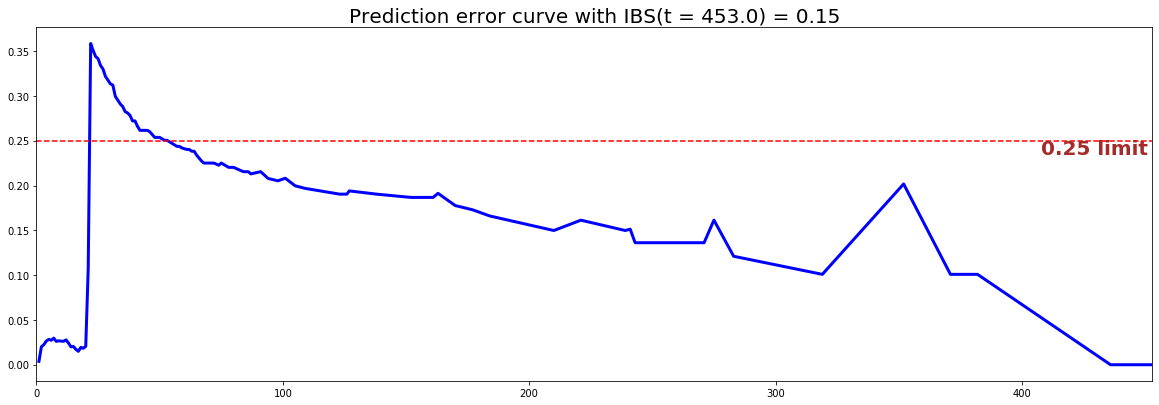

IBS: 0.15
CPU times: user 27.9 s, sys: 1.03 s, total: 29 s
Wall time: 29.3 s


In [70]:
#Standard CoxPH
%%time
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
#### 4 - Creating an instance of the NonLinear CoxPH model and fitting the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `BentIdentity` as its activation function
#structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
structure = [ {'activation': 'ReLU', 'num_units': 128}, {'activation': 'Tanh', 'num_units': 128},{'activation': 'BentIdentity', 'num_units': 128} ]

# Building the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='glorot_uniform')


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test) #0.96/0.13
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(nonlinear_coxph, X_test, T_test, E_test, t_max=600,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [0]:
k = 23

In [0]:
predicted = nonlinear_coxph.predict_survival(X_test.values[k, :], t=T_test.iloc[k]).flatten()

In [79]:
predicted

array([0.32958173])

In [78]:
E_test.iloc[k]

1

In [36]:
predicted

array([9.99999788e-01, 9.99991911e-01, 9.99951696e-01, 9.99760593e-01,
       9.99062970e-01, 9.96593644e-01, 9.87805829e-01, 9.57926028e-01,
       8.64741065e-01, 6.37638624e-01, 2.65777748e-01, 2.42062872e-02,
       3.51193007e-04, 2.79356518e-08, 6.62051397e-16, 1.14386056e-32,
       7.05853494e-67, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [0]:
#Cross Validation / Model Performances
c_index = concordance_index(coxph, X_test, T_test, E_test) #0.92
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(coxph, X_test, T_test, E_test, t_max=10,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

C-index: 0.81


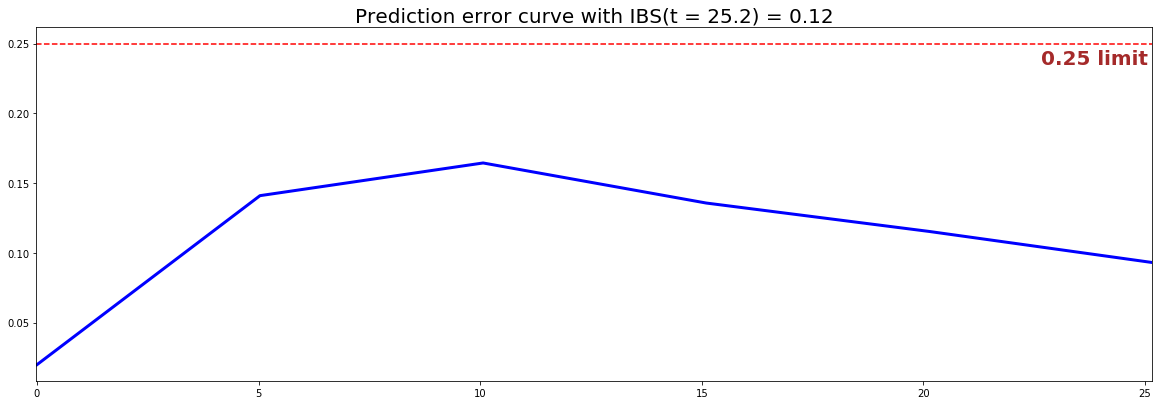

IBS: 0.12
CPU times: user 3.34 s, sys: 210 ms, total: 3.55 s
Wall time: 3.57 s


In [0]:
%%time
##5 -- best so far
from pysurvival.models.parametric import GompertzModel #try other models
# Building the model
gomp_model = GompertzModel()
gomp_model.fit(X_train, T_train, E_train, lr=1e-3, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-3, num_epochs=1500)


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(gomp_model, X_test, T_test, E_test) #0.77
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(gomp_model, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [69]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(NonLinearCoxPHModel, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

TypeError: ignored

In [0]:
%%time
##6
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1) #0.74

CPU times: user 4min 17s, sys: 90.6 ms, total: 4min 17s
Wall time: 2min 10s


C-index: 0.95


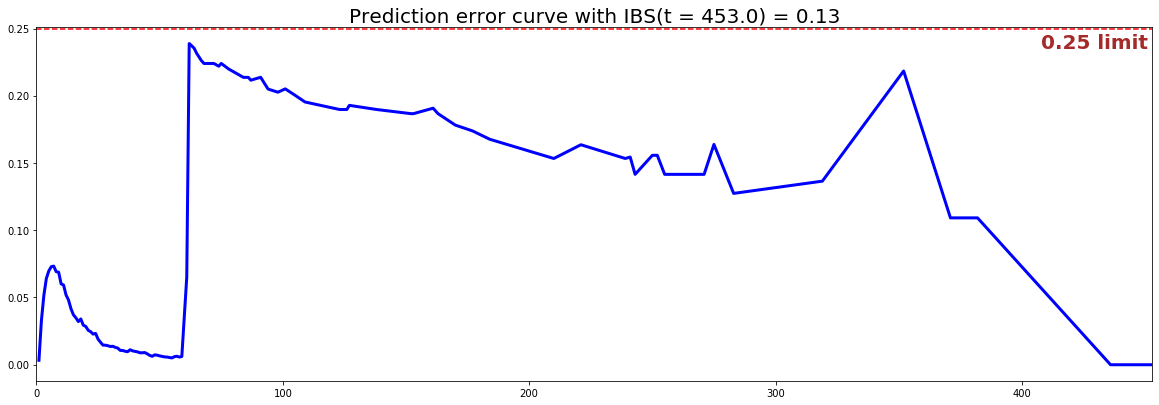

IBS: 0.13
CPU times: user 8.29 s, sys: 479 ms, total: 8.77 s
Wall time: 8.76 s


In [0]:
%%time
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
#### 4 - Creating an instance of the NonLinear CoxPH model and fitting the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `BentIdentity` as its activation function
structure = [ {'activation': 'BentIdentity', 'num_units': 256},  ]

# Building the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test) #0.95/0.13
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(nonlinear_coxph, X_test, T_test, E_test, t_max=600,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [0]:
# Computing variables importance
csf.variable_importance_table.head(20)

,feature,importance,pct_importance
0,CurrentAge,10.622006,0.137539
1,PolicyYear,7.178494,0.092951
2,EliminationPeriod_grouped_120+,5.163781,0.066863
3,productDesign_IncomeReplacement,4.970221,0.064357
4,EliminationPeriod_120,4.253302,0.055074
5,CurrentProvince_QC,3.492839,0.045227
6,productDesign_Proguard,3.121195,0.040415
7,benefitPeriod_grouped_ToAge65,2.895700,0.037495
8,OccupationClass_3A,2.707199,0.035054
9,DisabilityReason_Other cancer,2.123695,0.027499


In [0]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.83

C-index: 0.74
